In [1]:
# Useful libraries
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

In [2]:
# Define a couple of vector with their size.
IMG_SIZE = (720,240)
# NB1: In tensorflow and keras IMG_SIZE = (Height,width).
# NB2: Each image of dataset "DOS" has a size (240x270) pixel.

In [3]:
seed_value= 2022

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [4]:
BASE_MODEL='RESNET101V2'
N_Fold = 5

In [5]:
from keras.applications.resnet_v2 import ResNet101V2 as BModel, preprocess_input, decode_predictions
IMG_SIZE = (224,224,3)

In [6]:
# Function to read the images
def read_data1(img_number_init, img_number_fin):
    path = 'DOS\\imagesCropees\\'
    img = path + 'image'+str(img_number_init)+'.jpg'
    img = image.load_img(img, target_size=IMG_SIZE[0:2])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    for i in range(img_number_init+1,img_number_fin+1):
        img = path+'image'+str(i)+'.jpg'
        img = image.load_img(img, target_size=IMG_SIZE[0:2])
        xx = image.img_to_array(img)
        xx = np.expand_dims(xx, axis=0)
        x = np.vstack([x, xx])
        
    return x

In [7]:
def read_data2(img_number_init, img_number_fin):
    path = 'FLANC\\imagesCropees\\'
    img = path + 'image'+str(img_number_init)+'.jpg'
    img = image.load_img(img, target_size=IMG_SIZE[0:2])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    for i in range(img_number_init+1,img_number_fin+1):
        img = path+'image'+str(i)+'.jpg'
        img = image.load_img(img, target_size=IMG_SIZE[0:2])
        xx = image.img_to_array(img)
        xx = np.expand_dims(xx, axis=0)
        x = np.vstack([x, xx])
        
    return x

In [8]:
# Cleaning data
img_removed = [23, 43, 113, 153, 170, 187, 222, 230, 289, 316, 350, 395, 429, 483, 518, 541, 556, 566, 577, 652]
# NB : we need to remove the date cause "misunderstand" for the training procedures.
# Read data
nbr = len(img_removed)

X1 = read_data1(3, img_removed[0]-1)
X2 = read_data2(3, img_removed[0]-1)

for i in range(nbr-1):
    X1 = np.vstack([X1, read_data1(img_removed[i]+1, img_removed[i+1]-1)])

for i in range(nbr-1):
    X2 = np.vstack([X2, read_data2(img_removed[i]+1, img_removed[i+1]-1)])

# Normalize inputs
X1 = X1/255
X2 = X2/255

df = pd.read_excel ('classification.xlsx', engine='openpyxl')
# transform categorical to numeric
df['Eng'].replace([1,2,3,4],[0, 1, 2, 3], inplace=True)

In [9]:
y_all = df['Eng']
y_all = np.array(y_all)

y = y_all[1:img_removed[0]-1]

for i in range(nbr-1):
    y = np.hstack([y, y_all[img_removed[i]:img_removed[i+1]-1]])

y.shape

(630,)

In [10]:
# Separation of data in train-validation-test with rate of 60%-20%-20%
from sklearn.model_selection import train_test_split

X1 = preprocess_input(X1)
X1_train, X1_test, X2_train, X2_test,y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, shuffle=True, random_state=2)


In [11]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Flatten, BatchNormalization, concatenate
from tensorflow.keras.models import Model


def create_model():
    
    # load the convolutional base model and set layers as not trainable
    base_model = BModel(include_top=False, input_shape=IMG_SIZE)

    for layer in base_model.layers:
        layer.trainable = False

    input1 = Input(IMG_SIZE)
    input2 = Input(IMG_SIZE)
    
    x1 = base_model(input1)
    x2 = base_model(input2)
    
    # add new classifier layers
    x1 = layers.Flatten()(x1)
    x1 = layers.BatchNormalization()(x1)
    
    x2 = layers.Flatten()(x2)
    x2 = layers.BatchNormalization()(x2)
    
    x = concatenate([x1,x2])

    x = layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)

    output = layers.Dense(4, activation='softmax')(x)

    # define new model, compile and fit
    model = tensorflow.keras.Model(inputs=[input1,input2], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
# store the trained models in a list
list_of_models = []
list_of_histories = []
count = 0

# we use k-Fold (i.e. we will build k models)
kfold = StratifiedKFold(n_splits=N_Fold, shuffle=True, random_state=0)

                                    #pourquoi X1_train ici
for train_index, val_index in kfold.split(X1_train,y_train): 
    count = count + 1
    
    callbacks = [
        EarlyStopping(monitor = "val_accuracy",patience = 20),
        ModelCheckpoint(
        filepath = 'my_best_model'+str(count)+'.hdf5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1)
    ]

    model = create_model()
    
    # building the models
    history=model.fit([X1_train[train_index],X2_train[train_index]],y_train[train_index],epochs=100, batch_size = 64,
                   callbacks=callbacks,
                   validation_data = ([X1_train[val_index],X2_train[val_index]],y_train[val_index]))
                                                            #pourquoi X1_train
    list_of_models.append(model)
    list_of_histories.append(history)
    print('*************************')
    print('Training next model')
    print('*************************')

Epoch 1/100
7/7 [==============================] - 53s 1s/step - loss: 1.9092 - accuracy: 0.2829 - val_loss: 7.1505 - val_accuracy: 0.4950

Epoch 00001: val_accuracy improved from -inf to 0.49505, saving model to my_best_model1.hdf5


C:\Users\tnngo1\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
7/7 [==============================] - 3s 424ms/step - loss: 1.3921 - accuracy: 0.4467 - val_loss: 3.7021 - val_accuracy: 0.5347

Epoch 00002: val_accuracy improved from 0.49505 to 0.53465, saving model to my_best_model1.hdf5
Epoch 3/100
7/7 [==============================] - 3s 416ms/step - loss: 1.1422 - accuracy: 0.4988 - val_loss: 2.5133 - val_accuracy: 0.5545

Epoch 00003: val_accuracy improved from 0.53465 to 0.55446, saving model to my_best_model1.hdf5
Epoch 4/100
7/7 [==============================] - 3s 422ms/step - loss: 1.0223 - accuracy: 0.5633 - val_loss: 1.9865 - val_accuracy: 0.5347

Epoch 00004: val_accuracy did not improve from 0.55446
Epoch 5/100
7/7 [==============================] - 3s 423ms/step - loss: 0.8955 - accuracy: 0.6476 - val_loss: 1.6970 - val_accuracy: 0.5446

Epoch 00005: val_accuracy did not improve from 0.55446
Epoch 6/100
7/7 [==============================] - 3s 425ms/step - loss: 0.8594 - accuracy: 0.6526 - val_loss: 1.5117 - val_accura

7/7 [==============================] - 3s 424ms/step - loss: 0.4327 - accuracy: 0.8586 - val_loss: 1.4906 - val_accuracy: 0.5050

Epoch 00009: val_accuracy improved from 0.49505 to 0.50495, saving model to my_best_model2.hdf5
Epoch 10/100
7/7 [==============================] - 3s 424ms/step - loss: 0.4087 - accuracy: 0.8734 - val_loss: 1.4176 - val_accuracy: 0.5248

Epoch 00010: val_accuracy improved from 0.50495 to 0.52475, saving model to my_best_model2.hdf5
Epoch 11/100
7/7 [==============================] - 3s 426ms/step - loss: 0.3764 - accuracy: 0.8759 - val_loss: 1.3665 - val_accuracy: 0.5743

Epoch 00011: val_accuracy improved from 0.52475 to 0.57426, saving model to my_best_model2.hdf5
Epoch 12/100
7/7 [==============================] - 3s 425ms/step - loss: 0.2993 - accuracy: 0.9330 - val_loss: 1.3441 - val_accuracy: 0.6040

Epoch 00012: val_accuracy improved from 0.57426 to 0.60396, saving model to my_best_model2.hdf5
Epoch 13/100
7/7 [==============================] - 3s 42

7/7 [==============================] - 3s 429ms/step - loss: 0.0280 - accuracy: 0.9975 - val_loss: 1.6448 - val_accuracy: 0.5842

Epoch 00049: val_accuracy did not improve from 0.62376
Epoch 50/100
7/7 [==============================] - 3s 428ms/step - loss: 0.0403 - accuracy: 0.9926 - val_loss: 1.6499 - val_accuracy: 0.5842

Epoch 00050: val_accuracy did not improve from 0.62376
*************************
Training next model
*************************
Epoch 1/100
7/7 [==============================] - 13s 746ms/step - loss: 1.9175 - accuracy: 0.2978 - val_loss: 10.9136 - val_accuracy: 0.2970

Epoch 00001: val_accuracy improved from -inf to 0.29703, saving model to my_best_model3.hdf5
Epoch 2/100
7/7 [==============================] - 3s 426ms/step - loss: 1.3184 - accuracy: 0.4938 - val_loss: 5.1996 - val_accuracy: 0.2871

Epoch 00002: val_accuracy did not improve from 0.29703
Epoch 3/100
7/7 [==============================] - 3s 424ms/step - loss: 1.2426 - accuracy: 0.5236 - val_loss: 

7/7 [==============================] - 3s 432ms/step - loss: 0.0397 - accuracy: 0.9950 - val_loss: 1.5091 - val_accuracy: 0.5842

Epoch 00037: val_accuracy did not improve from 0.62376
Epoch 38/100
7/7 [==============================] - 3s 434ms/step - loss: 0.0485 - accuracy: 0.9950 - val_loss: 1.6669 - val_accuracy: 0.5842

Epoch 00038: val_accuracy did not improve from 0.62376
Epoch 39/100
7/7 [==============================] - 3s 431ms/step - loss: 0.0554 - accuracy: 0.9851 - val_loss: 1.6690 - val_accuracy: 0.5842

Epoch 00039: val_accuracy did not improve from 0.62376
Epoch 40/100
7/7 [==============================] - 3s 429ms/step - loss: 0.0529 - accuracy: 0.9876 - val_loss: 1.6174 - val_accuracy: 0.5644

Epoch 00040: val_accuracy did not improve from 0.62376
Epoch 41/100
7/7 [==============================] - 3s 429ms/step - loss: 0.0376 - accuracy: 0.9926 - val_loss: 1.5656 - val_accuracy: 0.5743

Epoch 00041: val_accuracy did not improve from 0.62376
Epoch 42/100
7/7 [=====

7/7 [==============================] - 3s 426ms/step - loss: 0.0738 - accuracy: 0.9901 - val_loss: 1.3219 - val_accuracy: 0.6139

Epoch 00028: val_accuracy did not improve from 0.62376
Epoch 29/100
7/7 [==============================] - 3s 427ms/step - loss: 0.0678 - accuracy: 0.9901 - val_loss: 1.3666 - val_accuracy: 0.6238

Epoch 00029: val_accuracy did not improve from 0.62376
Epoch 30/100
7/7 [==============================] - 3s 429ms/step - loss: 0.0864 - accuracy: 0.9801 - val_loss: 1.3973 - val_accuracy: 0.5941

Epoch 00030: val_accuracy did not improve from 0.62376
Epoch 31/100
7/7 [==============================] - 3s 429ms/step - loss: 0.0652 - accuracy: 0.9901 - val_loss: 1.4151 - val_accuracy: 0.6040

Epoch 00031: val_accuracy did not improve from 0.62376
Epoch 32/100
7/7 [==============================] - 3s 429ms/step - loss: 0.0617 - accuracy: 0.9901 - val_loss: 1.4425 - val_accuracy: 0.6139

Epoch 00032: val_accuracy did not improve from 0.62376
Epoch 33/100
7/7 [=====


Epoch 00003: val_accuracy did not improve from 0.61000
Epoch 4/100
7/7 [==============================] - 3s 426ms/step - loss: 0.9495 - accuracy: 0.5842 - val_loss: 2.3669 - val_accuracy: 0.5700

Epoch 00004: val_accuracy did not improve from 0.61000
Epoch 5/100
7/7 [==============================] - 3s 424ms/step - loss: 0.9725 - accuracy: 0.6064 - val_loss: 1.9599 - val_accuracy: 0.5900

Epoch 00005: val_accuracy did not improve from 0.61000
Epoch 6/100
7/7 [==============================] - 3s 424ms/step - loss: 0.7976 - accuracy: 0.6881 - val_loss: 1.7710 - val_accuracy: 0.5900

Epoch 00006: val_accuracy did not improve from 0.61000
Epoch 7/100
7/7 [==============================] - 3s 426ms/step - loss: 0.6547 - accuracy: 0.7624 - val_loss: 1.6407 - val_accuracy: 0.5800

Epoch 00007: val_accuracy did not improve from 0.61000
Epoch 8/100
7/7 [==============================] - 3s 427ms/step - loss: 0.6162 - accuracy: 0.7847 - val_loss: 1.5090 - val_accuracy: 0.5800

Epoch 00008: v

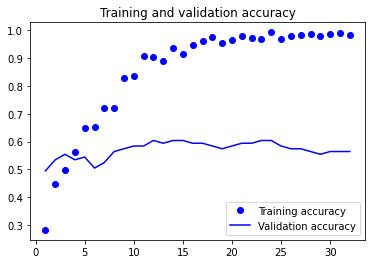

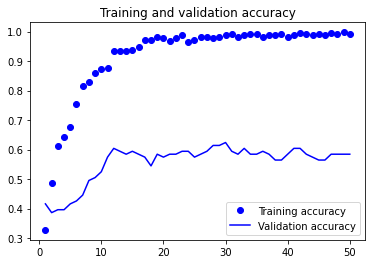

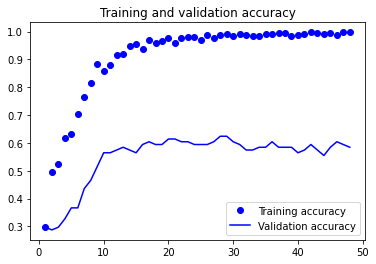

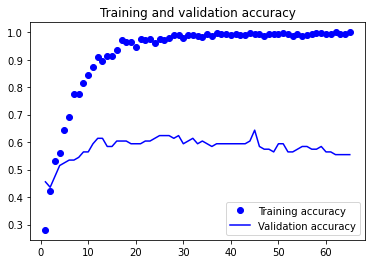

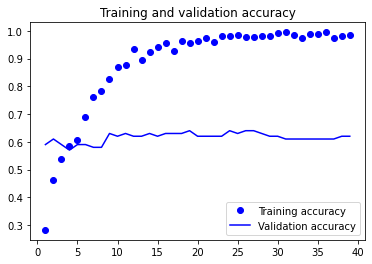

In [13]:
# Displaying curves of loss and accuracy during training

for i in range(5):
    acc = list_of_histories[i].history["accuracy"]
    val_acc = list_of_histories[i].history["val_accuracy"]
    loss = list_of_histories[i].history["loss"]
    val_loss = list_of_histories[i].history["val_loss"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.show()

In [17]:
from tensorflow.keras.models import load_model

all_model=[]

for i in range(N_Fold):
    all_model.append(load_model('my_best_model'+str(i+1)+'.hdf5'))

ResourceExhaustedError: OOM when allocating tensor with shape[200704,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [16]:
with tf.device('/cpu:0'):

    model_predict_moyenne = all_model[0].predict([X1_test,X2_test])

    for i in range(1,N_Fold):
        model_predict_moyenne = model_predict_moyenne + all_model[i].predict([X1_test,X2_test])

    model_predict_moyenne = model_predict_moyenne/N_Fold

    # Calcul précision de méthode k_fold
    print(np.mean(np.argmax(model_predict_moyenne, axis = 1)==y_test))

IndexError: list index out of range